# Github Bugs Predicition

## 1. Business Problem
### 1.1. Description
#### Problem Statement
* Title - the title of the GitHub bug, feature, question
* Body - the body of the GitHub bug, feature, question
* Label - Represents various classes of Labels
    1. Bug - 0
    2. Feature - 1
    3. Question - 2

### 2. Machine Learning Problem Formulation
#### 2.1. Data
##### 2.1.1. Data Overview
<i>Source-</i><a href="https://www.kaggle.com/anmolkumar/github-bugs-prediction">Kaggle</a>

#### 2.2. Mapping the real-world problem to an ML problem
##### 2.2.1. Type of Machine Learning Problem
This is a classification Problem

##### 2.2.2. Performance metric
* F1-Score

#### 3.Reading Data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [ ]:
train_df = pd.read_json("embold_train.json").reset_index(drop=True)
train_extra_df= pd.read_json("embold_train_extra.json")

In [ ]:
print(train_df.shape,train_extra_df.shape)

(150000, 3) (300000, 3)


In [ ]:
train_df.head()

,title,body,label
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0


1    69106
0    66827
2    14067
Name: label, dtype: int64


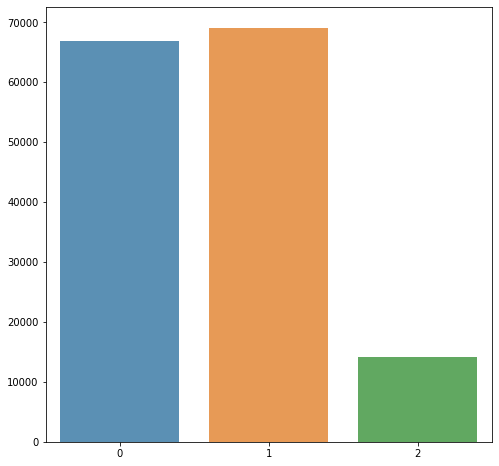

In [ ]:
label=train_df['label'].value_counts()
print(label)
plt.figure(figsize=(8,8))
sns.barplot(label.index, label.values, alpha=0.8)

plt.show()

1    138212
0    133654
2     28134
Name: label, dtype: int64


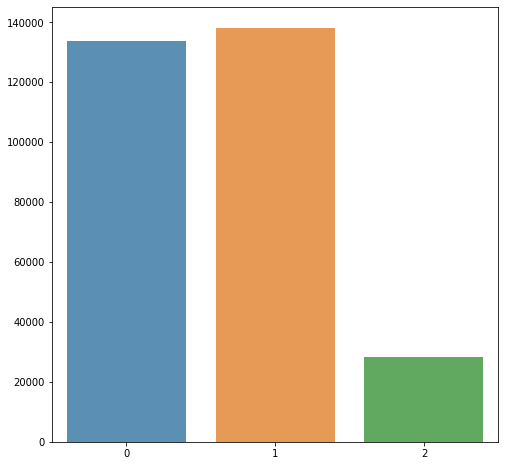

In [ ]:
label=train_extra_df['label'].value_counts()
print(label)
plt.figure(figsize=(8,8))
sns.barplot(label.index, label.values, alpha=0.8)

plt.show()

In [ ]:
!pip install transformers

In [ ]:
train_data = train_df.append(train_extra_df)
train_data['text'] = train_data['title']+' '+train_data['body']

In [ ]:
print(train_data.shape)
train_data.head()

(450000, 4)


,title,body,label,text
0,y-zoom piano roll,a y-zoom on the piano roll would be useful.,1,y-zoom piano roll a y-zoom on the piano roll w...
1,buggy behavior in selection,! screenshot from 2016-02-23 21 27 40 https:/...,0,buggy behavior in selection ! screenshot from ...
2,auto update feature,"hi,\r \r great job so far, @saenzramiro ! : \r...",1,"auto update feature hi,\r \r great job so far,..."
3,filter out noisy endpoints in logs,i think we should stop logging requests to:\r ...,1,filter out noisy endpoints in logs i think we ...
4,enable pid on / pid off alarm actions for ardu...,expected behavior\r alarm actions pid on and p...,0,enable pid on / pid off alarm actions for ardu...


In [ ]:
X=train_data["text"]
Y=train_data["label"]

#### 4.Train and Test Split

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=42,stratify=Y)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import transformers
from tokenizers import BertWordPieceTokenizer

import warnings
warnings.filterwarnings('ignore')

In [ ]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [ ]:
def build_model(transformer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    dense = Dense(128, activation='relu')(cls_token)
    dense = Dropout(0.2)(dense)
    out = Dense(3, activation='softmax')(dense)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 3
BATCH_SIZE = 32 
MAX_LEN = 200

In [ ]:
# First load the real tokenizer
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt')
fast_tokenizer

Tokenizer(vocabulary_size=30522, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=True, wordpieces_prefix=##)

In [ ]:
x_train = fast_encode(x_train, fast_tokenizer, maxlen=MAX_LEN)
x_test = fast_encode(x_test, fast_tokenizer, maxlen=MAX_LEN)

  0%|          | 0/1231 [00:00<?, ?it/s]

  0%|          | 0/528 [00:00<?, ?it/s]

In [ ]:
%%time
transformer_layer = (
    transformers.TFBertModel
    .from_pretrained('bert-base-uncased')
)
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_word_ids (InputLayer)  [(None, 200)]            0         
                                                                 
 tf_bert_model_3 (TFBertMode  TFBaseModelOutputWithPoo  109482240
 l)                          lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             200, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                           

#### 5.Training for 3 epochs

In [ ]:
train_history= model.fit(x_train,y_train,batch_size = BATCH_SIZE,epochs = EPOCHS)

Epoch 1/3
9844/9844 [==============================] - 7281s 738ms/step - loss: 0.4729 - accuracy: 0.8211
Epoch 2/3
9844/9844 [==============================] - 7262s 738ms/step - loss: 0.4116 - accuracy: 0.8470
Epoch 3/3
9844/9844 [==============================] - 7258s 737ms/step - loss: 0.3651 - accuracy: 0.8647


In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, ..., 0, 0, 0])

Accuracy on test set: 83.544%
F1-Score on test set: 0.774
-------------------- confusion matrix --------------------


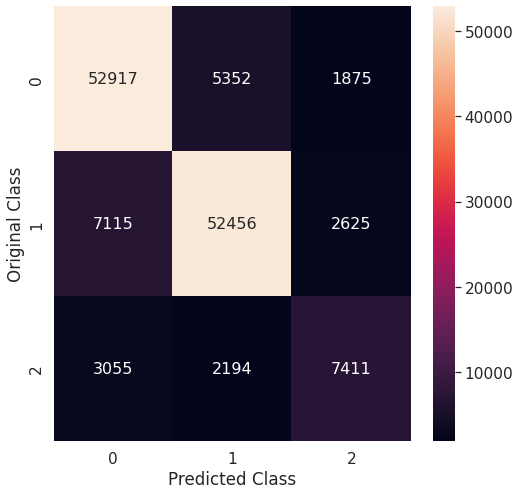

In [ ]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(8,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(3),range(3))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()

#### 6.Training for 1 more epochs

In [ ]:
train_history= model.fit(x_train,y_train,batch_size = BATCH_SIZE,epochs = 1)

9844/9844 [==============================] - 7260s 738ms/step - loss: 0.3127 - accuracy: 0.8852


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

y_pred = model.predict(x_test)
y_pred = np.round(y_pred).astype(int)

In [ ]:
y_pred=np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 1, ..., 0, 0, 0])

Accuracy on test set: 83.043%
F1-Score on test set: 0.767
-------------------- confusion matrix --------------------


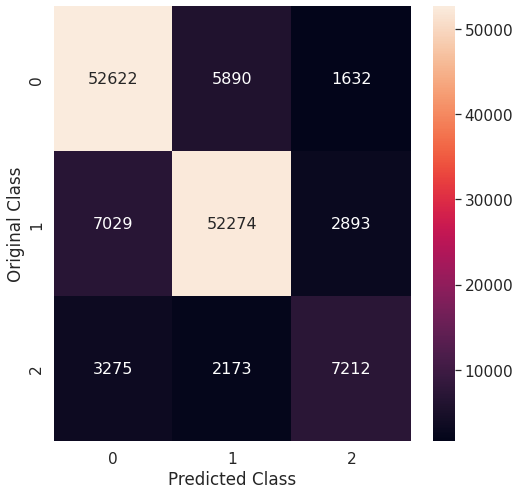

In [ ]:
print("Accuracy on test set: %0.3f%%"%(accuracy_score(y_test, y_pred)*100))
print("F1-Score on test set: %0.3f"%(f1_score(y_test, y_pred,average='macro')))
print("-"*20, "confusion matrix", "-"*20)
plt.figure(figsize=(8,8))
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(3),range(3))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, annot=True,annot_kws={"size": 16}, fmt='g')
plt.xlabel('Predicted Class')
plt.ylabel('Original Class')
plt.show()